# Section 27: Calculus, Cost Functions, and Gradient Descent

## Learning Objectives

- Review basics of calculus (if needed)
    - Derivatives
    - Integrals
    
- Discuss cost functions and how they work/are used (examples from Linear Regression).

- Discuss Cost Functions in Relation to Linear Regression
    - Walk through the process of estimating regression model and updating parameters 

- Discuss Gradient Descent's use of partial derivatives to approximate loss functions.



## Resources
- [Jeff's Study Group on Gradient Descent](https://youtu.be/G0EV4wcv0ok)

 Intro to Derivatives: Rates of Change

In [6]:
!pip install -U fsds_100719
from fsds_100719.imports import *

fsds_1007219  v0.5.2 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


## Cost Functions
- Defintion:
- Examples You've Seen/Used

### Examples - Equations




$$ \Large MSE = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat y_{i})^2$$

$$ \Large RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat y_{i})^2}$$



# Linear Regression Example Analogy for Loss Functions

In [11]:
## Kaggle Dataset https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

url = "https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/datasets/house-prices-advanced-regression-techniques/train.csv"

df = pd.read_csv(url)
display(df.head())
df.info()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [1]:
def reg_plot(df,x_col='GrLivArea',y_col='SalePrice'):
    fig,ax = plt.subplots(figsize=(10,6))

    ax.scatter(df[x_col],df[y_col],
              s=3,alpha=0.5,label='Raw Data')

    ax.set(**{"title":'Price vs Living Area',
             'ylabel':"Price",
             'xlabel':'GrLivArea'})
    ax.legend()


    fmtPrice = '$ {x:,.0f}'
    tickPrice = mpl.ticker.StrMethodFormatter(fmtPrice)
    ax.yaxis.set_major_formatter(tickPrice)
    return fig,ax
reg_plot(df)


In [50]:
x = df['GrLivArea']
y = df['SalePrice']

In [64]:
def regression_formula(x,slope,intercept,return_str=False):
    str_form = f"y={slope}*x + {intercept}"
    
    if return_str:
        return str_form
    else:
        return slope*x+intercept
    
def error(intercept, slope, x,y):
    totalError = 0
    for i in range(0,len(x)):
        totalError += (y[i] - (slope * x[i] + intercept)) ** 2
        
    return totalError / len(x)

def plot_scatter_vs_regr(df,x_col='GrLivArea',y_col='SalePrice',
                        slope=0, intercept=0):
    fig,ax = reg_plot(df,x_col=x_col,y_col=y_col)

    ax.plot(x,regression_formula(x,slope,intercept),
           ls=":",c='orange',lw=3,label='Regression Line')
    ax.legend()
    return fig,ax

In [65]:
regression_formula(x,my_slope,my_intercept)

0        8554
1        6314
2        8934
3        8589
4       10994
        ...  
1455     8239
1456    10369
1457    11704
1458     5394
1459     6284
Name: GrLivArea, Length: 1460, dtype: int64

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e9fef28>)

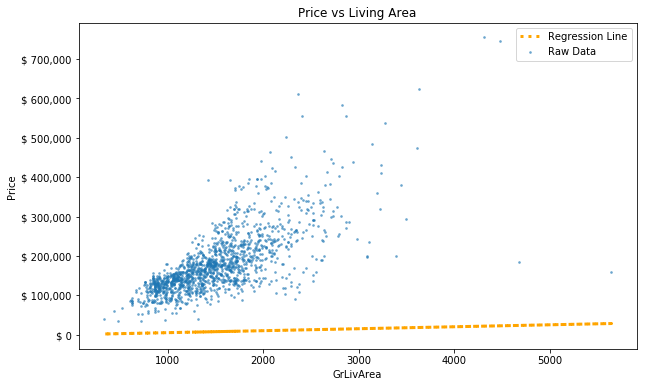

In [68]:
my_intercept=1
my_slope = 5
plot_scatter_vs_regr(df,slope=my_slope,intercept=my_intercept)

In [69]:
error(my_intercept,my_slope,x,y)

36065824190.3911

## Updating Our Guess


> Now that we are applying gradient descent to our cost curve $J(m, b)$, the technique should answer how much to move the $m$ variable and the $b$ variable to produce the greatest decrease in cost, or RSS. In other words, when altering our regression line, we want to know how much of this change should be derived from a move in the slope versus how much should be derived from a change in the y-intercept.


$$ \nabla J(m, b) = \frac{\delta J}{\delta m}, \frac{\delta J}{\delta b}$$


$$
\begin{align}
\frac{\delta J}{\delta m}J(m, b) & = \boldsymbol{\frac{\delta J}{\delta m}}(y - (mx + b))^2  &&\text{partial derivative with respect to} \textbf{ m}\\
\\
\frac{\delta J}{\delta b}J(m, b) & = \boldsymbol{\frac{\delta J}{\delta b}}(y - (mx + b))^2  &&\text{partial derivative with respect to} \textbf{ b}\\
\end{align}
$$

$ \frac{dJ}{dm}J(m,b) = -2\sum_{i = 1}^n x_i(y_i - (mx_i + b)) = -2\sum_{i = 1}^n x_i*\epsilon_i$
$ \frac{dJ}{db}J(m,b) = -2\sum_{i = 1}^n(y_i - (mx_i + b)) = -2\sum_{i = 1}^n \epsilon_i $

In [71]:
def loss_function(y,y_hat):
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(y,y_hat)
    
def step_parameters( x,y, slope, intercept,learning_rate):
    y_hat = regression_formula(x,slope,intercept)
    error_0=loss_function(y,y_hat)
    
    slope+=learning_rate
    intercept+=learning rate
    
#     error()

SyntaxError: invalid syntax (<ipython-input-71-f1acdb0ce11a>, line 7)

In [ ]:
def step_gradient(b_current, m_current, x, y, learning_rate):
    b_gradient = 0
    m_gradient = 0 
    N = len(x)
    
    for i in range(0, len(x)):
        m_gradient +=  -(2/N) * x[i] * (y[i] - (m_current * x[i] + b_current))
        b_gradient +=  -(2/N) * (y[i] - (m_current * x[i] + b_current))
    new_b = b_current - (learning_rate * b_gradient)
    new_m = m_current - (learning_rate * m_gradient)
    
    return (new_b, new_m)

# Derivatives Basics

- [Learn Lesson](https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/section-27-calculus-cost-function-and-gradient-descent/rules-for-derivatives)

## Rate of change for a (linear) function

Slope is rate the change for line --> rate is constant

For any two points:

$ \frac{\Delta y}{\Delta x} = \frac{y_2 - y_1}{x_2 - x_1}$

We can define this as a derivative:

$ 
f'(x) = \dfrac{\Delta y}{\Delta x} =  \dfrac{f(x + \Delta x) - f(x)}{\Delta x}
$

### In summary, derivates are:



$$ f'(x) = \dfrac{\text{rise}}{\text{run}} = \dfrac{\Delta y}{\Delta x} = \dfrac{y_2 - y_1}{x_2 - x_1} =  \dfrac{f(x_2) - f(x_1)}{x_2 - x_1}$$

$$\large f'(x) = \dfrac{f(x + \Delta x) - f(x)}{\Delta x}$$



* $f'(x)$ is the rate of change at a given value, or here the speed at a given time


* $f(x)$ is the distance at a given time


* $\Delta x$ is the elapsed time, or the change in $x$


* $f(x + \Delta x)$ is the distance at the starting time plus the elapsed time 



### For Non-Linear Functions

- [Derivatives on Non-Linear Functions](https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/section-27-calculus-cost-function-and-gradient-descent/derivatives-of-non-linear-functions)
$$\large f'(x) = \lim_{ h\to0} \frac{f(x + h) - f(x)}{h} $$ 

* where $h$ is used to represent $\Delta x$

### Power Rule

### Addition Terms & Coefficients

### The Chain Rule

$$h'(x) = (f\circ g)'(x) = f'(g(x)) \cdot g'(x)$$

$$\frac{dh}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx} = f'(y)g'(x) \text{  where } y = g(x)$$ 

# Finding Minimum & Maximum with Derivatives

Tops of hills

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Motivation from Linear Regression (Line of Best Fit)

- Cost function ==> residuals / error (RSS: residual sum of squares)

## Creating some random data

In [2]:
np.random.seed(27)

x = np.random.rand(30,1).reshape(30)
y_randterm = np.random.normal(0,3,30)
y = 3 + 50 * x + y_randterm

In [3]:
# Plotting a guess of a regression line
def regression_formula(x, b=2, a=30):
    return b + a*x

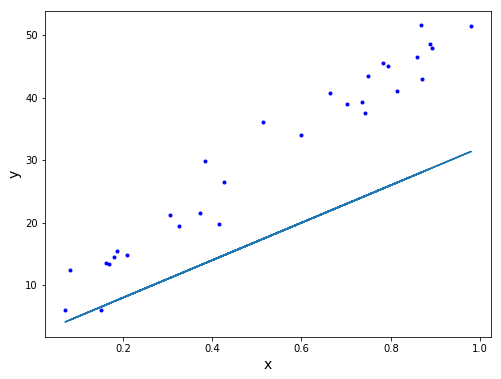

In [4]:
plt.figure(figsize=(8,6))
plt.plot(x, y, '.b')
plt.plot(x, regression_formula(x), '-')
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14);

In [5]:
residual_sum_squares(x,y,30,2)

NameError: name 'residual_sum_squares' is not defined

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(x, y, '.b')
plt.plot(x, regression_formula(x,3,55), '-')
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14);

In [ ]:
residual_sum_squares(x,y,50,3)

In [ ]:
# Analyzing the regression line
def errors(x_values, y_values, m, b):
    y_line = (b + m*x_values)
    return (y_values - y_line)

def squared_errors(x_values, y_values, m, b):
    return np.round(errors(x_values, y_values, m, b)**2, 2)

def residual_sum_squares(x_values, y_values, m, b):
    return round(sum(squared_errors(x_values, y_values, m, b)), 2)

In [ ]:
table = np.zeros((20,2))
for idx, val in enumerate(range(40, 60)):
    table[idx,0] = val
    table[idx,1] = residual_sum_squares(x, y, val, 1.319)
    
plt.figure(figsize=(10,7))
plt.plot(table[:,0], table[:,1], '-')
plt.xlabel("m-values", fontsize=14)
plt.ylabel("RSS", fontsize=14)
plt.title("RSS with changes to slope", fontsize=16);

# Intro to Gradient Descent

Adjust until it fits well enough

Judge by using the **cost curve**

## Stepping down a hill

More Slope --> bigger step

# Expanding Gradient Descent for Higher Dimensions

Partial Derivatives

Grad function $-\nabla = \sum_i \dfrac{\partial}{\partial x_i}$

<img src='images/gradientdescent.png' width=80%/>
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-gradient-descent-in-3d-online-ds-ft-100719/master/images/traveller-stepping.jpg" width=80%>

Lesson adapted from Jeff Herman: https://github.com/sik-flow/Study_Groups/blob/master/Gradient_Descent.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load in Data & Explore

In [2]:
# CSV from https://www.kaggle.com/c/house-prices-advanced-regression-techniques
df = pd.read_csv('data/house-prices-advanced-regression-techniques/train.csv')

FileNotFoundError: [Errno 2] File b'data/house-prices-advanced-regression-techniques/train.csv' does not exist: b'data/house-prices-advanced-regression-techniques/train.csv'

In [3]:
df.head()

NameError: name 'df' is not defined

In [4]:
df.columns

NameError: name 'df' is not defined

## Arbitrarily choosing a feature and target

We'll focus on the `GrLivAre` vs the `SalePrice` (target)

In [ ]:
x = df['GrLivArea']
y = df['SalePrice']

In [ ]:
plt.scatter(x, y)
plt.show()

Looks like there are some extreme values that might affect our linear regression

### Removing Outliers

In [ ]:
df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)]

In [ ]:
df.drop([523, 1298], inplace = True)
df.reset_index(inplace = True)

In [ ]:
x = df['GrLivArea']
y = df['SalePrice']

In [ ]:
plt.scatter(x, y)
plt.show()

# Our Linear Regression Line

In [ ]:
def regression_formula(x, slope, intercept):
    return slope * x + intercept

In [ ]:
my_slope = 0
my_intercept = 0

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Raw Data')
plt.plot(x, regression_formula(x, my_slope, my_intercept), color = 'k', label = 'Regression')
plt.legend()
plt.show()

In [ ]:
def error(intercept, slope, x, y):
    totalError = 0
    for i in range(0, len(x)):
        totalError += (y[i] - (slope * x[i] + intercept)) ** 2
    return totalError / len(x)

In [ ]:
error(my_intercept, my_slope, x, y)

## Gradient descent one step at a time

We need to find the gradient for each cost function (2-dimensions: b & m):

$$ \frac{\partial}{\partial b} (y_i - (b + ax_i))^2 = 2 \cdot (y_i-ax_i + b)$$

$$ \frac{\partial}{\partial a} (y_i - (b + ax_i))^2 = 2 \cdot x_i \cdot (y_i-ax_i + b)$$

In [ ]:
def partial_deriv(b, a, x_i, y_i, respect_to):
    if respect_to == 'b': 
        return (y_i - (a * x_i + b))
    elif respect_to == 'a':
        return (x_i * (y_i - (a * x_i + b)))
    else:
        print('Choose either respect_to: a or b ')
        return 0       

In [ ]:
def step_gradient(b, a, x, y, learning_rate):
    db = 0
    da = 0 
    # For each data point, update the derivative for the slope & intercept
    N = len(x)
    for i in range(len(x)):
        # Derivatives already pre-done
        
        # Partial derivatives of loss/cost function with respect to b & a
        db +=  -(2/N) * partial_deriv(b,a,x[i],y[i],respect_to='b')
        da +=  -(2/N) * partial_deriv(b,a,x[i],y[i],respect_to='a')
        
    # Adjust the slope & intercept by the gradient
    new_b = b - (learning_rate * db)
    new_a = a - (learning_rate * da)
    
    return (new_b, new_a)

### First Iteration

In [ ]:
first_step = step_gradient(my_intercept, my_slope, x, y, learning_rate=0.1)

In [ ]:
first_step

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Raw Data')
plt.plot(x, regression_formula(x, first_step[1], first_step[0]), 
         color = 'k', label = 'Regression')
plt.legend()
plt.show()

In [ ]:
error(my_intercept, my_slope, x, y)

In [ ]:
error(first_step[0], first_step[1], x, y)

In [ ]:
first_step = step_gradient(my_intercept, my_slope, x, y, learning_rate=0.00000001)

error(first_step[0], first_step[1], x, y)

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Raw Data')
plt.plot(x, regression_formula(x, first_step[1], first_step[0]), 
         color = 'k', label = 'Regression')
plt.legend()
plt.text(500, 650000, 'Iteration Number 1')
plt.text(500, 600000, f'Error {round(error(first_step[0], first_step[1], x, y), 0)}')
plt.show()

### Second Iteration

In [ ]:
second_step = step_gradient(first_step[0], first_step[1], x, y, learning_rate=0.00000001)

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Raw Data')
plt.plot(x, regression_formula(x, second_step[1], second_step[0]), 
         color = 'k', label = 'Regression')
plt.legend()
plt.text(500, 650000, 'Iteration Number 2')
plt.text(500, 600000, f'Error {round(error(second_step[0], second_step[1], x, y), 0)}')
plt.show()

### Third Iteration

In [ ]:
third_step = step_gradient(second_step[0], second_step[1], x, y, learning_rate=0.00000001)

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(x, y, label = 'Raw Data')
plt.plot(x, regression_formula(x, third_step[1], third_step[0]), 
         color = 'k', label = 'Regression')
plt.legend()
plt.text(500, 650000, 'Iteration Number 3')
plt.text(500, 600000, f'Error {round(error(third_step[0], third_step[1], x, y), 0)}')
plt.show()

## Multiple iterations

In [ ]:
errs = []
b = 0
m = 0

for i in range(100):
    err = error(b, m, x, y)
    errs.append(err)
    b, m = step_gradient(b, m, x, y, 0.00000001)

In [ ]:
plt.plot(range(100), errs)
plt.show()

Looks like we didn't have to do the full 100 since it doesn't do much better. We can do **early stopping** when the error doesn't change too much

In [ ]:
errs = []
b = 0
m = 0

for i in range(100):
    err = error(b, m, x, y)
    errs.append(err)
    b, m = step_gradient(b, m, x, y, 0.00000001)
    # Stop after errors don't change too much
    if len(errs) > 1:
        if (errs[-2] - errs[-1]) / errs[-2] < 0.01:
            print (i)
            break

In [ ]:
plt.plot(range(len(errs)), errs)
plt.show()

In [ ]:
errs = []
b = 0
m = 0

for i in range(100):
    err = error(b, m, x, y)
    errs.append(err)
    if (i > 1) & (i % 10 == 0):
        fig = plt.figure(figsize = (12, 8))
        ax1 = plt.subplot(1, 2, 1)
        ax1.scatter(x, y, label = 'Raw Data')
        ax1.plot(x, regression_formula(x, m, b), 
                 color = 'k', label = 'Regression')
        plt.legend()
        ax1.set_title(f'Iteration Number {i}')
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(range(i + 1), errs)
        ax2.set_title(f'Error {round(error(m, b, x, y), 0)}')
        plt.show()
    b, m = step_gradient(b, m, x, y, 0.00000001)

# Using Scikit-Learn

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))

In [ ]:
linreg.coef_[0][0]

In [ ]:
linreg.intercept_[0]

In [ ]:
m, b

In [ ]:
fig = plt.figure(figsize = (12, 8))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.scatter(x, y, label = 'Raw Data')
ax1.plot(x, regression_formula(x, m, b), 
         color = 'k', label = 'Regression')
ax1.set_title('Gradient Descent')
ax2.scatter(x, y, label = 'Raw Data')
ax2.plot(x, regression_formula(x, linreg.coef_[0][0], linreg.intercept_[0]), 
         color = 'k', label = 'Regression')
ax2.set_title('Sklearn')

In [ ]:
b

In [ ]:
np.sqrt(error(m, b, x, y))

In [ ]:
np.sqrt(error(linreg.coef_[0][0], linreg.intercept_[0], x, y))

In [ ]:
error(m, b, x, y)